# meiosis

> Fill in a module description here

In [ ]:
#| default_exp meiosis

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| hide
import jax
import jax.numpy as jnp
from chewc.sp import SimParam
from chewc.population import quick_haplo, Population
from chewc.trait import add_trait_a, TraitCollection
from chewc.pheno import set_pheno

# --- 1. JAX Setup ---
key = jax.random.PRNGKey(42)

# --- 2. Define the Genome's "Blueprint" ---
n_chr = 3
n_loci_per_chr = 100
ploidy = 2
gen_map = jnp.array([jnp.linspace(0, 1, n_loci_per_chr) for _ in range(n_chr)])
centromeres = jnp.full(n_chr, 0.5)

# --- 3. Instantiate Initial Simulation Parameters ---
SP = SimParam(
    gen_map=gen_map,
    centromere=centromeres,
    ploidy=ploidy
)

key, pop_key = jax.random.split(key)
n_founders = 50

founder_pop = quick_haplo(
    key=pop_key,
    sim_param=SP,
    n_ind=n_founders,
    inbred=False
)

SP = SP.replace(founderPop=founder_pop)
SP.founderPop.geno.shape # (50, 3, 2, 100) individuals,chromosomes, ploidy, markers


(50, 3, 2, 100)

In [ ]:
#| export

import jax
import jax.numpy as jnp
from jax import lax, vmap
from functools import partial
import matplotlib.pyplot as plt

@partial(jax.jit, static_argnames=("max_crossovers",))
def _sample_chiasmata(key: jax.random.PRNGKey, 
                      map_length: float, 
                      v: float, 
                      max_crossovers: int = 20) -> jnp.ndarray:
    """
    Generates crossover positions along a single chromosome using a Gamma process
    to model interference.
    """
    shape = v
    scale = 1.0 / (2.0 * v)

    def scan_body(carry, _):
        key, last_pos = carry
        key, subkey = jax.random.split(key)
        distance = jax.random.gamma(subkey, shape) * scale
        new_pos = last_pos + distance
        return (key, new_pos), new_pos

    key, initial_key = jax.random.split(key)
    initial_start_pos = jax.random.uniform(initial_key, minval=-10.0, maxval=0.0)
    init_carry = (key, initial_start_pos)
    
    _, crossover_positions = lax.scan(scan_body, init_carry, None, length=max_crossovers)
    
    # --- CORRECTED LOGIC ---
    # A crossover is only valid if it's within the bounds (0, map_length).
    valid_mask = (crossover_positions > 0) & (crossover_positions < map_length)
    valid_crossovers = jnp.where(valid_mask, 
                                 crossover_positions, 
                                 jnp.nan)
    
    return valid_crossovers


✅ Validated `_sample_chiasmata` over 10000 runs.
Chromosome Length (Morgans): 1.00
Average number of crossovers: 1.86

Plotting the distribution of crossover counts...


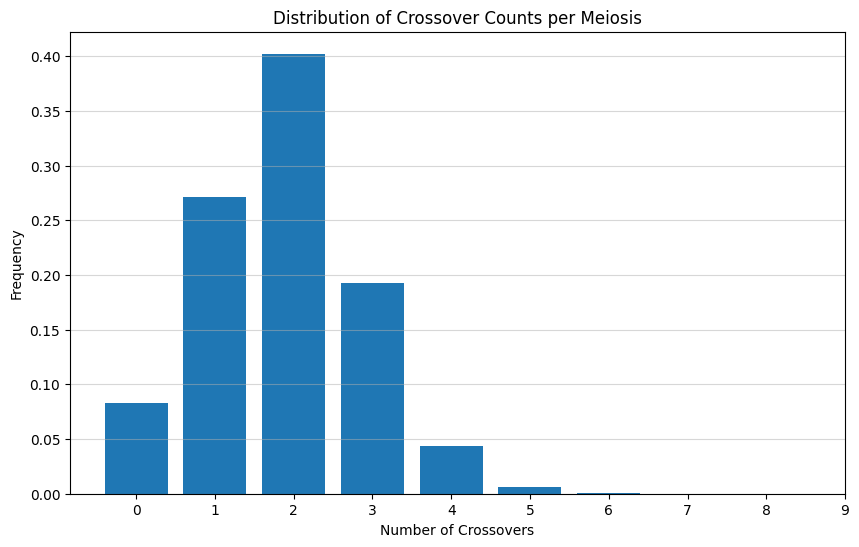

In [ ]:

# --- Validation (using the corrected function) ---

# --- Setup ---
v_interference = SP.recomb_params[0]
map_len_chr0 = SP.gen_map[0, -1].item() # .item() gets the scalar value
key, val_key = jax.random.split(key)
validation_keys = jax.random.split(val_key, 10000)

# --- Run ---
# The lambda function to count valid (non-NaN) crossovers is now correct.
get_n_crossovers = jax.jit(jax.vmap(lambda k: jnp.sum(~jnp.isnan(
    _sample_chiasmata(k, map_len_chr0, v_interference)
))))
num_crossovers_per_run = get_n_crossovers(validation_keys)

# --- Analyze and Report ---
avg_crossovers = num_crossovers_per_run.mean()
print(f"✅ Validated `_sample_chiasmata` over {validation_keys.shape[0]} runs.")
print(f"Chromosome Length (Morgans): {map_len_chr0:.2f}")
print(f"Average number of crossovers: {avg_crossovers:.2f}")

# --- Visualize ---
print("\nPlotting the distribution of crossover counts...")
plt.figure(figsize=(10, 6))
plt.hist(num_crossovers_per_run, bins=jnp.arange(0, 10), density=True, align='left', rwidth=0.8)
plt.title("Distribution of Crossover Counts per Meiosis")
plt.xlabel("Number of Crossovers")
plt.ylabel("Frequency")
plt.xticks(jnp.arange(0, 10))
plt.grid(axis='y', alpha=0.5)
plt.show()

In [ ]:
@partial(jax.jit, static_argnames=("max_crossovers",))
def _create_gamete(key: jax.random.PRNGKey, 
                   parental_haplotypes: jnp.ndarray,
                   gen_map: jnp.ndarray,
                   v_interference: float,
                   max_crossovers: int = 20) -> jnp.ndarray:
    """
    Creates a single recombinant gamete from a parent's two haplotypes.
    """
    key, chiasma_key, hap_key = jax.random.split(key, 3)

    map_length = gen_map[-1]
    
    crossover_positions = _sample_chiasmata(chiasma_key, map_length, 
                                            v_interference, max_crossovers)

    crossover_indices = jnp.searchsorted(gen_map, crossover_positions)

    start_hap = jax.random.choice(hap_key, jnp.array([0, 1], dtype=jnp.uint8))

    n_loci = gen_map.shape[0]
    
    # --- FIX ---
    # Use side='right' to ensure the crossover happens at the correct locus index.
    locus_segments = jnp.searchsorted(crossover_indices, jnp.arange(n_loci), side='right')
    
    haplotype_choice = (start_hap + locus_segments) % 2
    
    new_gamete = jnp.where(haplotype_choice == 0, 
                           parental_haplotypes[0], 
                           parental_haplotypes[1])
    
    return new_gamete


In [ ]:
# --- Validation Setup ---
parental_genos = jnp.array([
    jnp.zeros(SP.gen_map.shape[1], dtype=jnp.uint8),
    jnp.ones(SP.gen_map.shape[1], dtype=jnp.uint8)
])

# --- FIX in the mock function ---
def mock_sample_chiasmata(key, map_length, v, max_crossovers=20):
    """A deterministic mock for testing _create_gamete."""
    crossover_pos = SP.gen_map[0, 40]
    # Fill the array with NaNs, then set the first element to our desired position.
    return jnp.full((max_crossovers,), fill_value=jnp.nan).at[0].set(crossover_pos)

original_sampler = _sample_chiasmata
_sample_chiasmata = mock_sample_chiasmata

# --- Run Validation (No changes needed here) ---
test_key = jax.random.PRNGKey(0)
v_interference = SP.recomb_params[0]
gamete = _create_gamete(test_key, parental_genos, SP.gen_map[0], v_interference)

# --- Analyze and Report Results (No changes needed here) ---
print("Validating _create_gamete with a single, fixed crossover at locus 40:")
print("Below: Slices from indexes 35:45 for parental haplotypes")
print("Parent Haplotype 0:", parental_genos[0, 35:45])
print("Parent Haplotype 1:", parental_genos[1, 35:45])
print("Resulting Gamete:  ", gamete[35:45])

is_correct_a = jnp.all(gamete[:40] == 0) and jnp.all(gamete[40:] == 1)
is_correct_b = jnp.all(gamete[:40] == 1) and jnp.all(gamete[40:] == 0)

assert is_correct_a or is_correct_b, "Gamete was not formed correctly!"
print("\n✅ Validation successful: Gamete correctly stitched together.")

# --- Cleanup ---
_sample_chiasmata = original_sampler

Validating _create_gamete with a single, fixed crossover at locus 40:
Below: Slices from indexes 35:45 for parental haplotypes
Parent Haplotype 0: [0 0 0 0 0 0 0 0 0 0]
Parent Haplotype 1: [1 1 1 1 1 1 1 1 1 1]
Resulting Gamete:   [1 1 1 1 1 0 0 0 0 0]

✅ Validation successful: Gamete correctly stitched together.


In [ ]:
#| export
# The signature and decorator are changed to be more specific and JIT-friendly.
@partial(jax.jit, static_argnames=("n_chr",))
def _meiosis_for_one_cross(key: jax.random.PRNGKey,
                           mother_geno: jnp.ndarray,
                           father_geno: jnp.ndarray,
                           n_chr: int,
                           gen_map: jnp.ndarray,
                           v_interference: float
                          ) -> jnp.ndarray:
    """
    Creates a single diploid progeny from two parents.
    """
    key_mother, key_father = jax.random.split(key)
    
    # vmap now gets its arguments directly
    vmapped_gamete_creator = vmap(
        _create_gamete, 
        in_axes=(0, 0, 0, None)
    )

    mother_gametes = vmapped_gamete_creator(
        jax.random.split(key_mother, n_chr),
        mother_geno,
        gen_map,
        v_interference
    )

    father_gametes = vmapped_gamete_creator(
        jax.random.split(key_father, n_chr),
        father_geno,
        gen_map,
        v_interference
    )

    progeny_geno = jnp.stack([mother_gametes, father_gametes], axis=1)
    
    return progeny_geno

In [ ]:
# --- Setup (Unchanged)---
parent1_geno = founder_pop.geno[0]
parent2_geno = founder_pop.geno[1]

# Make sure we are using the real sampler
_sample_chiasmata = original_sampler 

# --- Run Validation (with corrected call) ---
key, cross_key = jax.random.split(key)

# FIX: Call the function with specific arguments instead of the whole SP object
progeny_geno = _meiosis_for_one_cross(cross_key, 
                                      parent1_geno, 
                                      parent2_geno,
                                      SP.n_chr,
                                      SP.gen_map,
                                      SP.recomb_params[0])

# --- Analyze and Report Results (Unchanged) ---
print("Validating `_meiosis_for_one_cross`:")
print(f"Shape of Mother's Genotype: {parent1_geno.shape}")
print(f"Shape of Progeny's Genotype: {progeny_geno.shape}")

assert progeny_geno.shape == parent1_geno.shape, "Progeny genotype shape is incorrect!"
assert progeny_geno.dtype == jnp.uint8, "Progeny genotype dtype is incorrect!"
assert not jnp.all(progeny_geno == parent1_geno), "Progeny is an exact clone of the mother!"
assert not jnp.all(progeny_geno == parent2_geno), "Progeny is an exact clone of the father!"

print("\n✅ Validation successful: Progeny genotype has the correct shape and is not a parental clone.")

Validating `_meiosis_for_one_cross`:
Shape of Mother's Genotype: (3, 2, 100)
Shape of Progeny's Genotype: (3, 2, 100)

✅ Validation successful: Progeny genotype has the correct shape and is not a parental clone.


In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()